In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, round_tree, sampling, data_loading

import torch
from adabmDCA.functional import one_hot
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)

<module 'energy_models' from '/home/scrotti/Aptamer2025py/energy_models.py'>

In [75]:
q = 4
L = 45

k = torch.randn(L, q)
h = torch.randn(L, q)
J = torch.randn(L, q, L, q)

rt = round_tree.RoundTree(n_modes=2)
rt.add_node(-1, torch.BoolTensor([1, 0]))
rt.add_node(0, torch.BoolTensor([1, 0]))

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
ps = selex_distribution.MultiModeDistribution(potts, energy_models.InfiniteEnergy(), normalized=False)

# def perceptron(L):
#     return torch.nn.Sequential(
#         torch.nn.Linear(L*q, 1),
#         torch.torch.nn.Softmax(dim=0)
#     )

# nns = [energy_models.GenericEnergyModel(perceptron(L)) for _ in range(2)]
# ps = selex_distribution.MultiModeDistribution(*nns, normalized=False)

Nst = selex_distribution.MultiRoundDistribution(Ns0, ps, rt)

M = 10
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [4]:
chains = torch.zeros(M, L, q)
chains[:, :, 0] = 1

t = 1
def compute_energy(x):
    return Nst.compute_energy_up_to_round(x, t)

sampling.metropolis_step_uniform_sites(chains, compute_energy)
sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=10)

In [5]:
energies = [compute_energy(chains).mean().detach().numpy()]
N = 100
for i_ in tqdm(range(N)):
    sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=1, beta=4.0)
    energies.append(compute_energy(chains).mean().detach().numpy())

100%|███████████████████| 100/100 [00:01<00:00, 51.45it/s]


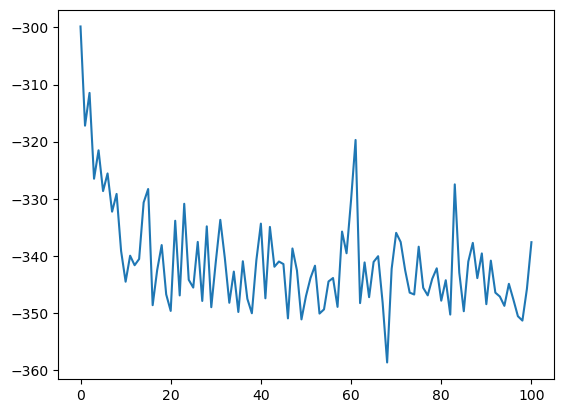

In [6]:
plt.plot(energies);

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import adabmDCA
from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.functional import one_hot

import sys
sys.path.append('..')
import selex_dca, utils

In [8]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [10]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [11]:
sequences_oh = [one_hot(seq, num_classes=q).to(dtype) for seq in sequences]

In [153]:
def init_chains(
    n_rounds: int,
    n_chains: int,
    L: int,
    q: int,
    device: torch.device,
    dtype: torch.dtype | None = None,
) -> torch.Tensor:

    if dtype is None:
        dtype = torch.float32
    chains = [torch.randint(low=0, high=q, size=(n_chains, L), device=device)
            for _ in range(n_rounds)]
    
    chains_tensor = torch.stack([one_hot(c, num_classes=q).to(dtype) for c in chains])
    
    return chains_tensor   # n_rounds, n_chains, L, q

def update_chains(chains, t, model, n_sweeps):
    compute_energy = lambda x : model.compute_energy_up_to_round(x, t-1)
    sampling.sample_metropolis_uniform_sites(chains[t], compute_energy, n_sweeps)

def compute_pearson(grad_model, grad_empirical):
    x = torch.nn.utils.parameters_to_vector(grad_model)
    y = torch.nn.utils.parameters_to_vector(grad_empirical)
    return torch.corrcoef(torch.stack([x, y]))[0, 1].item()

def init_history():
    history = {
        "pearson": [],
        "nLtilde": [],
        "pi": []
    }
    return history

In [154]:
from tqdm.autonotebook import tqdm

def compute_gradient_at_round(model, chains, data_batch, t):
    # this L is not physically a likelihood, more like a computational trick
    L_model = model.selection_energy_at_round(chains, t).mean() \
                    + model.compute_energy_up_to_parent_round(chains, t).mean()
    L_empirical = model.selection_energy_at_round(data_batch, t).mean() \
                    + model.compute_energy_up_to_parent_round(data_batch, t).mean()
    return L_model, L_empirical

def compute_gradient(model, L_model, L_empirical):
    params = tuple(model.parameters())

    # Compute gradients for L_model
    grad_model = torch.autograd.grad(
        outputs=L_model,
        inputs=params,
        retain_graph=True,  # Need this because we'll compute gradients again
        create_graph=False
    )
    
    # Compute gradients for L_empirical
    grad_empirical = torch.autograd.grad(
        outputs=L_empirical,
        inputs=params,
        retain_graph=False,
        create_graph=False
    )
    
    grad_total = tuple(-(gm - ge) for gm, ge in zip(grad_model, grad_empirical))
    
    with torch.no_grad():
        for p, g in zip(model.parameters(), grad_total):
            p.grad = g
            
    nL_total = - (L_model - L_empirical)

    return nL_total, grad_total, grad_model, grad_empirical

def train(
    model: selex_distribution.MultiRoundDistribution,
    data_loaders,
    chains: torch.Tensor,
    n_sweeps: int,
    lr: float,    
    max_epochs: int,
    target_pearson = 1.0,
    l2reg: float = 0.0,
    history : dict = init_history(),
    progress_bar: bool = True,
):
    n_rounds = len(data_loaders) 
    assert chains.shape[0] == n_rounds
    loaders = [iter(dl) for dl in data_loaders]
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2reg)

    def halt_condition(epochs, pearson):
        c1 = epochs > max_epochs
        c2 = pearson >= target_pearson
        return c1 or c2

    epochs = 0
    pearson = -1
    if progress_bar: 
        pbar = tqdm(
            initial=0,
            total=max_epochs,
            colour="red",
            dynamic_ncols=True,
            leave=False,
            ascii="-#",
            bar_format="{desc} {percentage:.2f}%[{bar}] Epoch: {n}/{total_fmt} [{elapsed}]"
        )
    while not halt_condition(epochs, pearson):
        optimizer.zero_grad()
        L_model = L_empirical = 0
        for t in range(n_rounds):
            # update chains
            with torch.no_grad():
                update_chains(chains, t, model, n_sweeps)
            # extract batch of data from round t
            data_batch = next(loaders[t])
            # compute gradient
            L_mod, L_emp = compute_gradient_at_round(model, chains[t].clone(), data_batch, t-1)
            L_model = L_model + L_mod
            L_empirical = L_empirical + L_emp
            # TODO: compute round-wise convergence metrics

        # compute gradient
        nL_total, grad_total, grad_model, grad_empirical = compute_gradient(model, L_model, L_empirical)
        # do gradient step on params
        optimizer.step()

        # convergence metrics
        pearson = compute_pearson(grad_model, grad_empirical)
        # TODO: callbacks
        pi = model.round_zero.h.detach().exp()
        pi /= pi.sum(dim=1, keepdim=True)
        history["pi"].append(pi)

        epochs += 1
        if progress_bar:
            pbar.n = epochs
            pbar.set_description(f"Epoch {epochs}, Pearson = {pearson:.3f}, -L = {nL_total:.3f}")

        history["pearson"].append(pearson)
        history["nLtilde"].append(nL_total)

In [185]:
k = torch.zeros(L, q)
h = torch.zeros(L, q)
J = torch.zeros(L, q, L, q)

rt = round_tree.RoundTree(n_modes=2)
rt.add_node(-1, torch.BoolTensor([1, 0]))
rt.add_node(0, torch.BoolTensor([1, 0]))

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
ps = selex_distribution.MultiModeDistribution(potts, energy_models.InfiniteEnergy(), normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, rt)

In [205]:
batch_size = 2**14
n_chains = batch_size

datasets = [data_loading.SelexRoundDataset(seq_oh) for seq_oh in sequences_oh]
data_loaders = [torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in datasets]
n_rounds = len(data_loaders) 
history = init_history()
chains = init_chains(n_rounds, n_chains, L, q, device)

In [ ]:
n_sweeps = 10
lr = 0.01
max_epochs = 2000

train(model, data_loaders, chains, n_sweeps, lr, max_epochs, history=history)

 0.00%[                                                       ] Epoch: 0/2000 [00:00]

In [145]:
fi, fij, Rt = utils.frequences_from_sequences_oh(sequences_oh[0])

In [ ]:
pi = history["pi"][-1]
x = pi.view(-1)
y = fi.view(-1)
plt.scatter(x, y)
plt.xlim((0,1))
plt.ylim((0,1))

In [ ]:
pearsons = []
for pi in history["pi"]:
    x = pi.view(-1)
    y = fi.view(-1)
    pearsons.append(torch.corrcoef(torch.stack([x, y]))[0, 1].item())

plt.plot(pearsons)

In [ ]:
plt.plot(history["pearson"])

<IPython.core.display.Latex object>

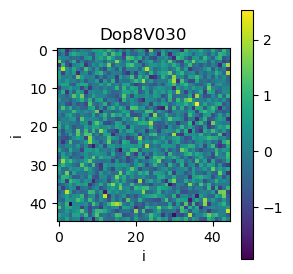

In [105]:
from IPython.display import display, Latex

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))